## SFL 

#### With two arm bandit task and agents on a fully connected network


In [1]:
library(igraph)


Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




In [2]:
N <- 10
net <- make_full_graph(N, directed=FALSE)

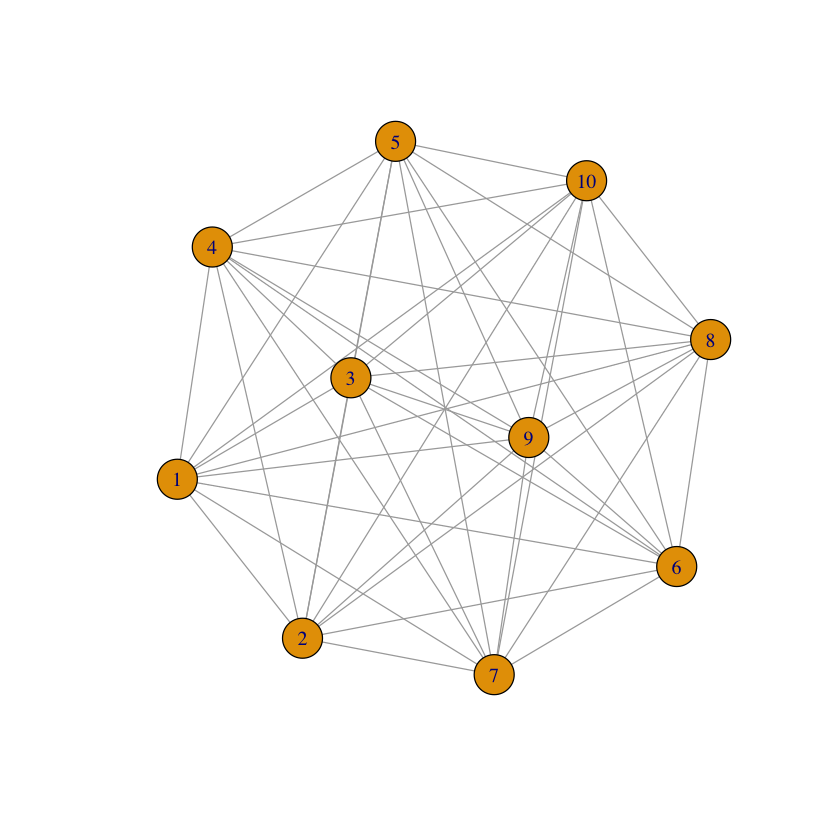

In [3]:
plot(net)

In [9]:

get_softmax <- function(q_values, beta) {
  exp_vals <- exp(q_values / beta)
  probs <- exp_vals / sum(exp_vals)
  return(probs)
}

get_similarity <- function(feat_self, feat_other) {
  return(if (feat_self == feat_other) 1 else 0) # basic check if feature has the same value or not
}

simple_SFL <- function(N = 5, timesteps = 100, 
                       alpha = 0.01, beta = 1,
                       similar_agents = FALSE) {

  net <- make_full_graph(N, directed=FALSE)


  agent_features <- if(similar_agents) rep(1, N) else sample(0:1, N, prob = c(0.5, 0.5), replace = TRUE)
  
  # weight matrix for all features
  weights <- matrix(0, nrow = N, ncol = 4)
  
  for (t in 1:timesteps) {

    for (i in 1:N) {

      # select a neighbor
      neighbors <- setdiff(1:N, i)
      chosen_neighbor <- sample(neighbors, 1)

      # binary similarity between agent i and neighbor
      similarity_val <- get_similarity(agent_features[i], agent_features[chosen_neighbor])
      
      # simulate neighbor's choice
      nb_choice <- sample(1:2, size = 1, prob = c(1, 0))
      
      # observed choice of neighbor
      nb_choice_feat <- c(as.numeric(nb_choice == 1), as.numeric(nb_choice == 2))
      
      # non social feature value of arms
      intrinsic_arm1 <- c(1, 0)
      intrinsic_arm2 <- c(0, 1)
      
      # combined feature values of arms for agent i
      features_arm1 <- c(intrinsic_arm1, similarity_val, nb_choice_feat[1])
      features_arm2 <- c(intrinsic_arm2, similarity_val, nb_choice_feat[2])
      
      Q_arm1 <- sum(weights[i, ] * features_arm1)
      Q_arm2 <- sum(weights[i, ] * features_arm2)
      Q_values <- c(Q_arm1, Q_arm2)
      
      action_probs <- get_softmax(Q_values, beta)
      
      choice <- sample(1:2, size = 1, prob = action_probs)

      reward <- rbinom(1, 1, c(0.8, 0.2)[choice])

      
      # prediction error
      delta <- reward - Q_values[choice]
      
      # update weights for the chosen arm
      weights[i, ] <- weights[i, ] + alpha * delta * (if(choice == 1) features_arm1 else features_arm2)

    }
  }
  return(list(weights = weights))
}

In [10]:
diverse <- simple_SFL(N = 10, timesteps = 10000, similar_agents = FALSE)
homogeneous <- simple_SFL(N = 10, timesteps = 10000, similar_agents = TRUE)

print(colMeans(diverse$weights))
print(colMeans(homogeneous$weights))


[1]  0.403259789  0.203343244 -0.005096129  0.403259789
[1]  0.27995650 -0.04016817  0.23978833  0.27995650
